In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('inputs/CONOSCE_CONTRATACIONDIRECTA.csv')

In [3]:
df.columns

Index(['CODIGOENTIDAD', 'RUC_ENTIDAD', 'ENTIDAD', 'ENTIDAD_DEPARTAMENTO',
       'ENTIDAD_PROVINCIA', 'ENTIDAD_DISTRITO', 'FECHACONVOCATORIA',
       'OBJETOCONTRACTUAL', 'PROCESO', 'CODIGOCONVOCATORIA',
       'DESCRIPCION_PROCESO', 'NUMERO_ITEM', 'ITEMCONVOCA_DESCRIPCION',
       'ITEMCONVOCA_UNIDADMEDIDA', 'SECTOR', 'TIPOENTIDADOEE', 'TIPOPROCESO',
       'ITEM_DEPARTAMENTO', 'ITEM_PROVINCIA', 'ITEM_DISTRITO',
       'ESTADOITEMCONVOCA', 'ULTIMO', 'MONEDA', 'CAUSAL_EXOR_CONT_DIRECTA',
       'MONTOREFERENCIAL', 'MONTOREFERENCIALSOLES', 'MONTOADJUDICADO',
       'MONTOADJUDICADOSOLES', 'CANTIDADADJUDICADA', 'TIPOPROVEEDOR',
       'RUCPROVEEDOR', 'PROVEEDOR', 'RUCDETALLEPROVEEDOR', 'DETALLEPROVEEDOR',
       'URLFICHAPROCESO', 'RUBROS'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CODIGOENTIDAD             8946 non-null   int64  
 1   RUC_ENTIDAD               8946 non-null   int64  
 2   ENTIDAD                   8946 non-null   object 
 3   ENTIDAD_DEPARTAMENTO      8946 non-null   object 
 4   ENTIDAD_PROVINCIA         8946 non-null   object 
 5   ENTIDAD_DISTRITO          8946 non-null   object 
 6   FECHACONVOCATORIA         8946 non-null   object 
 7   OBJETOCONTRACTUAL         8946 non-null   object 
 8   PROCESO                   8946 non-null   object 
 9   CODIGOCONVOCATORIA        8946 non-null   int64  
 10  DESCRIPCION_PROCESO       8946 non-null   object 
 11  NUMERO_ITEM               8946 non-null   int64  
 12  ITEMCONVOCA_DESCRIPCION   8946 non-null   object 
 13  ITEMCONVOCA_UNIDADMEDIDA  8946 non-null   object 
 14  SECTOR  

In [5]:
df['ENTIDAD'].describe()

count                       8946
unique                      1788
top       SEGURO SOCIAL DE SALUD
freq                         648
Name: ENTIDAD, dtype: object

In [6]:
df['RUC_ENTIDAD'].unique().shape

(1788,)

In [7]:
df['PROVEEDOR'].describe()

count                                                8941
unique                                               3927
top       L & M MEDICAL SUPPLIES SOCIEDAD ANONIMA CERRADA
freq                                                   71
Name: PROVEEDOR, dtype: object

In [8]:
df['RUCPROVEEDOR'].unique().shape

(3933,)

In [12]:
departamentos = gpd.read_file('inputs/DEPARTAMENTOS/')

In [13]:
pob_x_departamentos = pd.read_csv('inputs/pob_x_departamento.csv')

In [14]:
pob_x_departamentos['DEPARTAMEN'] = pob_x_departamentos['Departamento'].str.normalize('NFKD')\
    .str.encode('ascii', errors='ignore')\
    .str.decode('utf-8')\
    .str.upper()

In [15]:
dept_con_pob = pd.merge(
    pob_x_departamentos,
    departamentos,
    on='DEPARTAMEN'
)

In [16]:
dept_con_pob_geo = pd.merge(
    dept_con_pob,
    df.groupby('ENTIDAD_DEPARTAMENTO')['MONTOADJUDICADO'].sum(),
    left_on='DEPARTAMEN',
    right_index=True,
)

In [17]:
dept_con_pob_geo['Poblacion Estimada 2020'] = dept_con_pob_geo['Población Estimado 2020'].str.replace(' ', '').astype(int)

In [18]:
dept_con_pob_geo['Monto Per Capita'] = dept_con_pob_geo['MONTOADJUDICADO'] / dept_con_pob_geo['Poblacion Estimada 2020']

In [23]:
dept_con_pob_geo['Densidad 2017 (hab/km²)'] = dept_con_pob_geo['Densidad\n2017 (hab/km²)'].str.replace(',', '.').astype(float)

In [26]:
dept_con_pob_geo['Superficie (km²)'] = dept_con_pob_geo['Superficie\n(km²)'].str.replace(' ', '').str.replace(',', '.').astype(float)

In [27]:
dept_con_pob_geo = gpd.GeoDataFrame(dept_con_pob_geo)

In [28]:
dept_con_pob_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

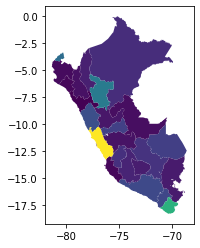

In [29]:
dept_con_pob_geo.plot('Monto Per Capita')

In [30]:
dept_con_pob_geo.columns

Index(['Departamento', 'Superficie\n(km²)', 'Población Censo 2017',
       'Población Estimado 2020', 'Densidad\n2017 (hab/km²)', 'DEPARTAMEN',
       'IDDPTO', 'CAPITAL', 'FUENTE', 'geometry', 'MONTOADJUDICADO',
       'Poblacion Estimada 2020', 'Monto Per Capita',
       'Densidad 2017 (hab/km²)', 'Superficie (km²)'],
      dtype='object')

In [31]:
dept_con_pob_geo['Monto Adjudicado'] = dept_con_pob_geo['MONTOADJUDICADO']

In [35]:
dept_con_pob_geo['Departamento'] = dept_con_pob_geo['DEPARTAMEN']

In [36]:
selected_vars = ['Departamento', 'Poblacion Estimada 2020', 'Superficie (km²)', 'Densidad 2017 (hab/km²)', 'Monto Adjudicado', 'Monto Per Capita', 'geometry',]

In [37]:
dept_con_pob_geo[selected_vars].to_file('inputs/departamentos.geojson', driver='GeoJSON')